In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from catboost import CatBoostRegressor
from data.data_generator import generate_house_prices_dataset
import scipy.stats as stats
from scipy.stats import norm
from scipy.interpolate import UnivariateSpline
from sklearn import datasets
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from pygam import LinearGAM, s

In [2]:
# house_prices_df = generate_house_prices_dataset(num_samples=5000, random_seed=42)
# # Split the data into features and target
# X = house_prices_df.drop('house_price', axis=1)
# y = house_prices_df['house_price']
# # Define categorical features
# cat_features = ['location_category', 'property_condition']
# house_prices_df.head()

In [3]:
# Step 1: Load the dataset
data = fetch_california_housing()
X, y = pd.DataFrame(data.data), pd.DataFrame(data.target)  # Features and target
cat_features = None

In [4]:

# # Load Iris dataset
# iris = datasets.load_iris()
# X = pd.DataFrame(iris.data[:, 1:])  # Use Petal Length, Petal Width, and Sepal Width as features
# y = pd.DataFrame(iris.data[:, 0])   # Predict Sepal Length (regression task)
# cat_features = None

In [5]:

# First split: 70% train, 30% temp (which will be split into val and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Second split: Split the temp set into validation and test (50% each, which is 15% of original data)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# # Scale the target variable
# scaler_y = MinMaxScaler()
# y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
# y_val = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
# y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Print the shapes to verify the splits
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 14448 samples
Validation set: 3096 samples
Test set: 3096 samples


(array([33.,  6.,  4.,  4.,  3.,  3.,  4.,  4.,  6., 33.]),
 array([1.48598099e-12, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

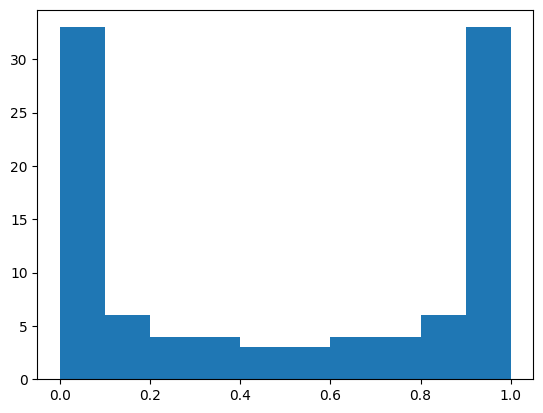

In [6]:
# Uniformly spaced quantiles
uniform_quantiles = np.linspace(0.01, 0.99, 100)

# Transform using normal distribution's PPF
non_uniform_quantiles = stats.norm.cdf(stats.norm.ppf(uniform_quantiles) * 3)

# Ensure values are within [0,1]
non_uniform_quantiles = np.clip(non_uniform_quantiles, 0, 1)

quantiles = non_uniform_quantiles
plt.hist(quantiles) 

In [7]:
trained_models = {}

In [8]:
# Identify categorical features
num_iter = 100

for q in tqdm(quantiles):
    # Define quantile loss function
    quantile_loss = f'Quantile:alpha={q}'

    # Create CatBoostRegressor model
    model = CatBoostRegressor(cat_features=cat_features, loss_function=quantile_loss, iterations=num_iter, subsample=1.0,random_seed=42)

    # Train the model
    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True, verbose=False)

    # Add the model to the trained_models dictionary
    trained_models[q] = model


100%|██████████| 100/100 [00:24<00:00,  4.07it/s]


In [9]:
# Get predictions for each quantile
y_pred = []
for i in tqdm(range(len(X_test))):
    y_pred.append([])
    for q in quantiles:
        y_pred[i].append(trained_models[q].predict(X_test.iloc[i].values.reshape(1, -1)))
y_pred = np.array(y_pred)
y_pred.shape

100%|██████████| 3096/3096 [01:33<00:00, 33.24it/s]


(3096, 100, 1)

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


  6% (6 of 100) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 12% (12 of 100) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 19% (19 of 100) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 26% (26 of 100) |#####                  | Elapsed Time: 0:00:00 ETA:   0:00:00
 33% (33 of 100) |#######                | Elapsed Time: 0:00:00 ETA:   0:00:00
 38% (38 of 100) |########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (45 of 100) |##########             | Elapsed Time: 0:00:00 ETA:   0:00:00
 52% (52 of 100) |###########            | Elapsed Time: 0:00:00 ETA:   0:00:00
 59% (59 of 100) |#############          | Elapsed Time: 0:00:00 ETA:   0:00:00


did not converge


 66% (66 of 100) |###############        | Elapsed Time: 0:00:00 ETA:   0:00:00
 73% (73 of 100) |################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 80% (80 of 100) |##################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 87% (87 of 100) |####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
 94% (94 of 100) |#####################  | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Optimal lambda: [[0.001]]


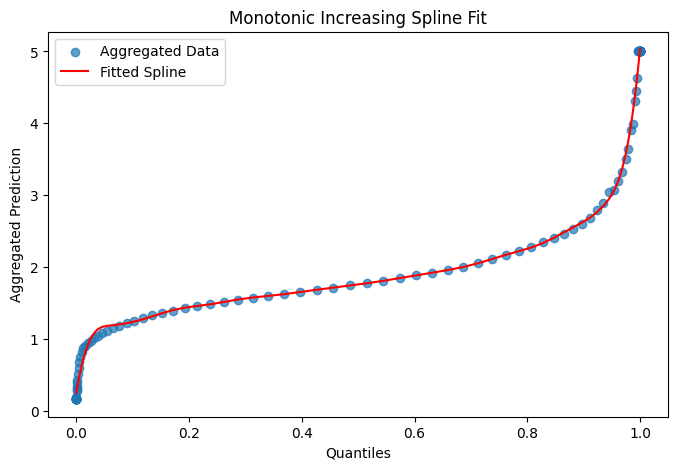

In [10]:
# Aggregate y_pred across all samples
y_pred_aggregated = np.median(y_pred, axis=0)  # Median reduces impact of outliers; alternatively, use mean

# Define lambda range for grid search
lambda_range = np.logspace(-3, 3, 100)

# Fit a single GAM on the aggregated data
gam = LinearGAM(s(0, constraints="monotonic_inc")).fit(quantiles, y_pred_aggregated)

# Perform grid search to find optimal lambda
gam.gridsearch(quantiles, y_pred_aggregated, lam=lambda_range, keep_best=True)

# Retrieve the optimal lambda
best_lambda = gam.lam

print(f"Optimal lambda: {best_lambda}")

# Plot the fitted spline
plt.figure(figsize=(8, 5))
plt.scatter(quantiles, y_pred_aggregated, label="Aggregated Data", alpha=0.7)
plt.plot(quantiles, gam.predict(quantiles), color="red", label="Fitted Spline")
plt.xlabel("Quantiles")
plt.ylabel("Aggregated Prediction")
plt.title("Monotonic Increasing Spline Fit")
plt.legend()
plt.show()


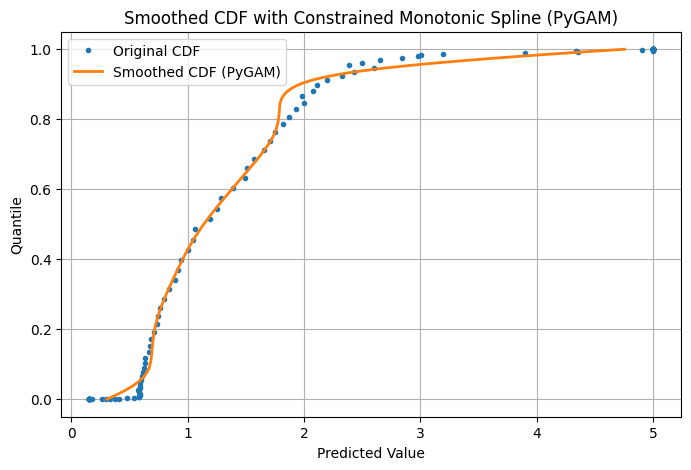

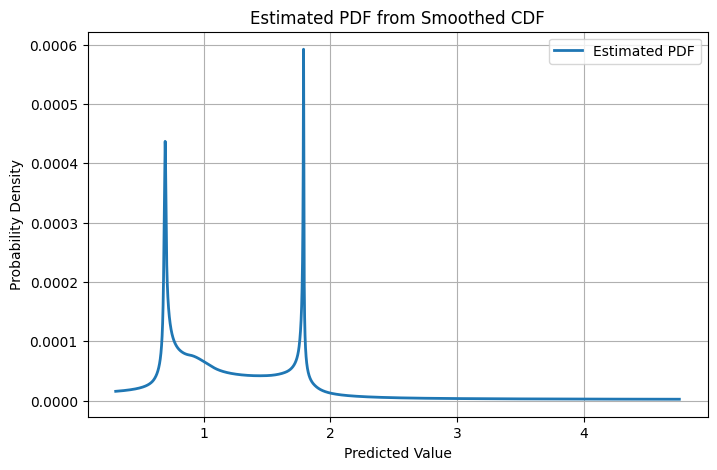

In [11]:
i = 0

# Fit a monotonic increasing spline using PyGAM
y_pred_sample = y_pred[i].flatten()

# # Compute extrapolated tail values using a logistic-like shape
# extra_margin = 0.5  # Adjust this to control smoothness at tails

# quantiles_extra_low = np.linspace(quantiles.min() - extra_margin, quantiles.min(), num=5)
# quantiles_extra_high = np.linspace(quantiles.max(), quantiles.max() + extra_margin, num=5)

# # Generate y_pred_sample values that smoothly extend to the tails
# y_extra_low = np.linspace(y_pred_sample.min() - extra_margin, y_pred_sample.min(), num=5)
# y_extra_high = np.linspace(y_pred_sample.max(), y_pred_sample.max() + extra_margin, num=5)

# # Combine extended and original points
# quantiles_extended = np.hstack([quantiles_extra_low, quantiles, quantiles_extra_high])
# y_pred_sample_extended = np.hstack([y_extra_low, y_pred_sample, y_extra_high])

# Fit a Generalized Additive Model with monotonic increasing constraint
gam = LinearGAM(s(0, constraints="monotonic_inc")).fit(quantiles, y_pred_sample)
# gam.gridsearch(quantiles, y_pred_sample, lam=np.logspace(-3, 3, 100), keep_best=True)
# gam.gridsearch(quantiles, y_pred_sample, keep_best=True)


# Generate a smooth curve for prediction
quantiles_smooth = np.linspace(0, quantiles.max(), 10000)
y_pred_smooth = gam.predict(quantiles_smooth)


# Compute the PDF as the derivative of the CDF
epsilon = 1e-10  # Small constant to avoid division by zero
# Compute the PDF as the derivative of the CDF
pdf_smooth = np.diff(quantiles_smooth) / (np.diff(y_pred_smooth) + epsilon)
pdf_smooth = np.pad(pdf_smooth, (0, 1), mode='edge')  # Extend last value
pdf_smooth /= np.sum(pdf_smooth)


# Plot results
plt.figure(figsize=(8, 5))
plt.plot(y_pred_sample, quantiles, ".", label="Original CDF")  # Dots for raw CDF
plt.plot(y_pred_smooth, quantiles_smooth, "-", label="Smoothed CDF (PyGAM)", linewidth=2)
plt.xlabel("Predicted Value")
plt.ylabel("Quantile")
plt.title("Smoothed CDF with Constrained Monotonic Spline (PyGAM)")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 5))
plt.plot(y_pred_smooth, pdf_smooth, "-", label="Estimated PDF", linewidth=2)
plt.xlabel("Predicted Value")
plt.ylabel("Probability Density")
plt.title("Estimated PDF from Smoothed CDF")
plt.legend()
plt.grid(True)
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.show()

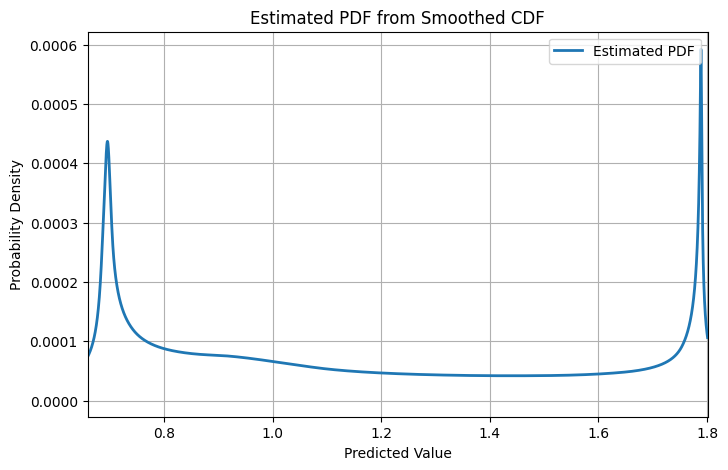

In [12]:
# Assuming y_pred_smooth and pdf_smooth are already computed
# Compute CDF of the estimated PDF
cdf_smooth = np.cumsum(pdf_smooth)
cdf_smooth /= cdf_smooth[-1]  # Normalize to ensure the last value is 1

# Find the indices for 2.5% and 97.5% percentiles
lower_idx = np.searchsorted(cdf_smooth, 0.025)
upper_idx = np.searchsorted(cdf_smooth, 0.975)

# Determine x-limits
x_min, x_max = y_pred_smooth[lower_idx], y_pred_smooth[upper_idx]

# Plot the PDF with x-axis limited to 95% of the density
plt.figure(figsize=(8, 5))
plt.plot(y_pred_smooth, pdf_smooth, "-", label="Estimated PDF", linewidth=2)
plt.xlabel("Predicted Value")
plt.ylabel("Probability Density")
plt.title("Estimated PDF from Smoothed CDF")
plt.legend()
plt.grid(True)

# Apply x-axis limit to focus on the central 95% of the density
plt.xlim(x_min, x_max)

plt.show()


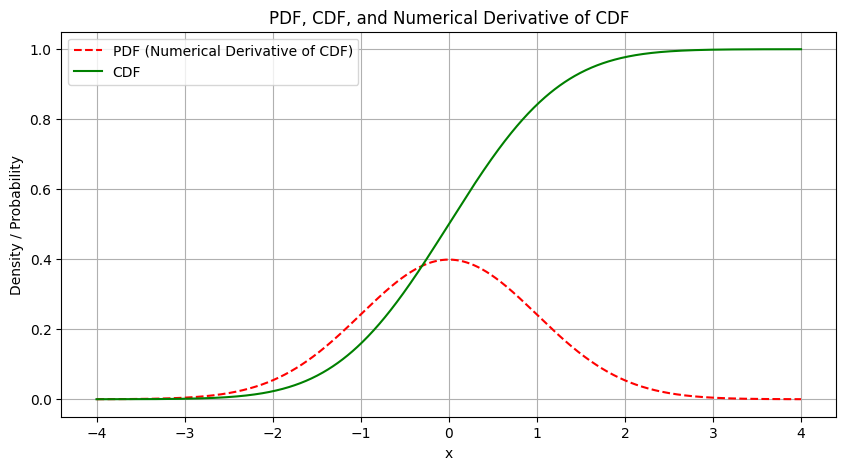

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the range of x values
x = np.linspace(-4, 4, 1000)

# Compute the PDF and CDF of the normal distribution
cdf_values = norm.cdf(x, loc=0, scale=1)  # Standard Normal CDF

# Compute the derivative of the CDF (numerical differentiation)
numerical_pdf = np.gradient(cdf_values, x)

# Plot the PDF and the derivative of the CDF
plt.figure(figsize=(10, 5))

# plt.plot(x, pdf_values, label="PDF (Analytical)", color="blue")
plt.plot(x, numerical_pdf, '--', label="PDF (Numerical Derivative of CDF)", color="red")
plt.plot(x, cdf_values, label="CDF", color="green")

plt.legend()
plt.xlabel("x")
plt.ylabel("Density / Probability")
plt.title("PDF, CDF, and Numerical Derivative of CDF")
plt.grid()

plt.show()


Epoch 0, Train Loss: 0.041234, Val Loss: 0.913132
Epoch 500, Train Loss: 0.002141, Val Loss: 0.136502
Epoch 1000, Train Loss: 0.001500, Val Loss: 0.082334
Epoch 1500, Train Loss: 0.001264, Val Loss: 0.043741
Epoch 2000, Train Loss: 0.001013, Val Loss: 0.035158
Epoch 2500, Train Loss: 0.000836, Val Loss: 0.023106
Epoch 3000, Train Loss: 0.000725, Val Loss: 0.013854
Epoch 3500, Train Loss: 0.000653, Val Loss: 0.008963
Epoch 4000, Train Loss: 0.000613, Val Loss: 0.003729
Epoch 4500, Train Loss: 0.000531, Val Loss: 0.004212
Epoch 5000, Train Loss: 0.000563, Val Loss: 0.001068
Epoch 5500, Train Loss: 0.000386, Val Loss: 0.001199
Epoch 6000, Train Loss: 0.000342, Val Loss: 0.001839
Epoch 6500, Train Loss: 0.000384, Val Loss: 0.002113
Epoch 7000, Train Loss: 0.000268, Val Loss: 0.005988
Epoch 7500, Train Loss: 0.000262, Val Loss: 0.009641
Epoch 8000, Train Loss: 0.000234, Val Loss: 0.010993
Epoch 8500, Train Loss: 0.000186, Val Loss: 0.010506
Epoch 9000, Train Loss: 0.000191, Val Loss: 0.0086

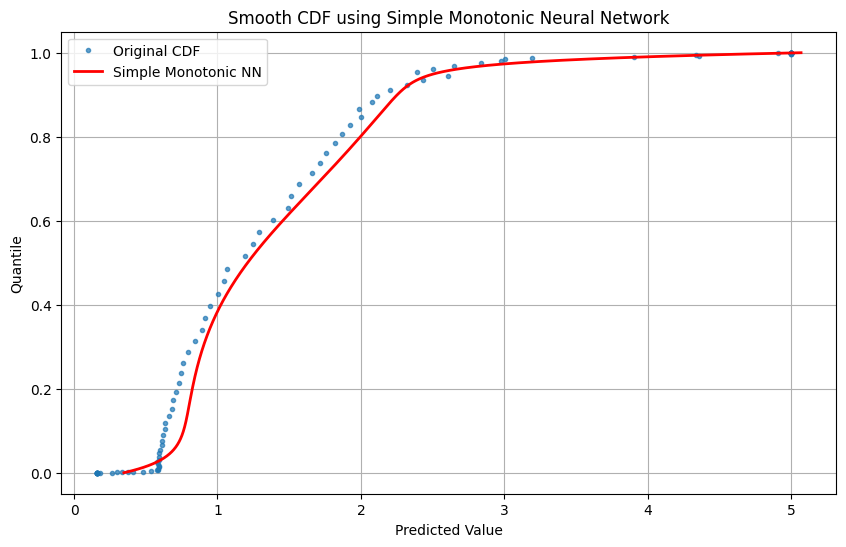

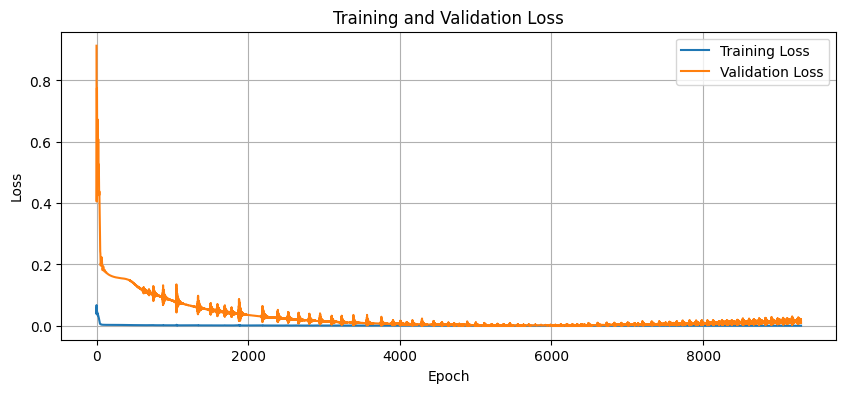

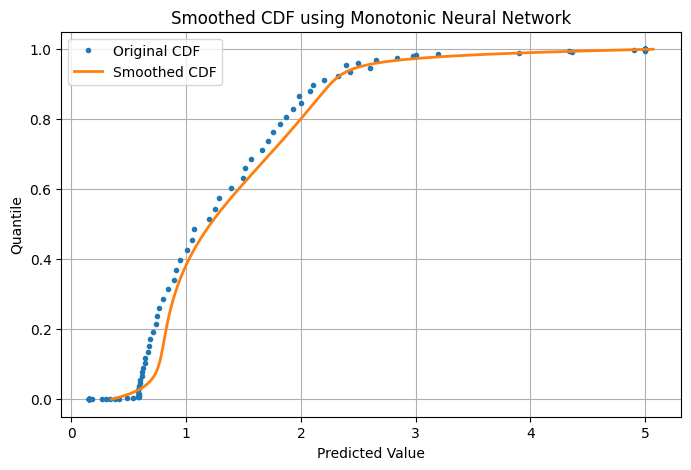

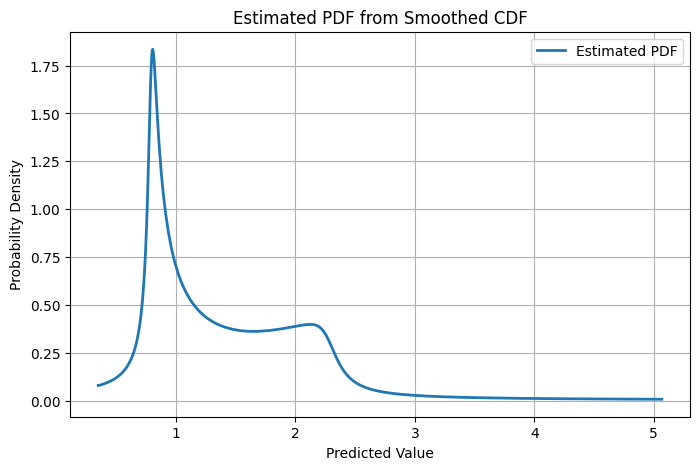

In [14]:
from monotonic_cdf_smoother import smooth_cdf, predict
import numpy as np
import matplotlib.pyplot as plt

# Smooth the CDF
model, y_pred_smooth, quantiles_smooth = smooth_cdf(
    quantiles, 
    y_pred_sample, 
    hidden_size=8, 
    num_epochs=50000,
    lr=0.05, 
    patience=5000,  # Stop if no improvement for 500 epochs
    min_delta=1e-10  # Minimum improvement to reset patience counter
)

# Generate a finer grid for better PDF estimation
fine_grid = np.linspace(0, 1, 1000)
y_pred_fine = predict(
    model, 
    fine_grid, 
    x_min=quantiles.min(), 
    x_max=quantiles.max(),
    y_min=y_pred_sample.min(), 
    y_max=y_pred_sample.max()
)

# Sort by y_pred values (important for correct derivative calculation)
sort_idx = np.argsort(y_pred_fine)
y_pred_sorted = y_pred_fine[sort_idx]
quantiles_sorted = fine_grid[sort_idx]

# Compute the PDF as the derivative of the CDF
# For a CDF, the PDF is the derivative of the quantile with respect to the value
pdf_smooth = np.gradient(quantiles_sorted, y_pred_sorted)

# Normalize the PDF so it integrates to 1
area = np.trapz(pdf_smooth, y_pred_sorted)
pdf_smooth = pdf_smooth / area

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(y_pred_sample, quantiles, ".", label="Original CDF")  # Dots for raw CDF
plt.plot(y_pred_smooth, quantiles_smooth, "-", label="Smoothed CDF", linewidth=2)
plt.xlabel("Predicted Value")
plt.ylabel("Quantile")
plt.title("Smoothed CDF using Monotonic Neural Network")
plt.legend()
plt.grid(True)
plt.show()

# Plot the PDF
plt.figure(figsize=(8, 5))
plt.plot(y_pred_sorted, pdf_smooth, "-", label="Estimated PDF", linewidth=2)
plt.xlabel("Predicted Value")
plt.ylabel("Probability Density")
plt.title("Estimated PDF from Smoothed CDF")
plt.legend()
plt.grid(True)
plt.show()